In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import rdMolAlign, rdFreeSASA, Descriptors
import numpy as np

from sklearn.metrics import mean_absolute_error, recall_score, precision_score, f1_score, confusion_matrix
from scipy.stats import spearmanr

sns.set_theme(style="whitegrid")

In [5]:
esen_d = pd.concat(
    [
        pd.read_parquet("./ligboundconf_2p1_esen-s-d_1of2.parquet"), 
        pd.read_parquet("./ligboundconf_2p1_esen-s-d_2of2.parquet")
    ]
)
esen_d = esen_d.reset_index(drop=True)
esen_d["esen_d_strain"] = esen_d.local_min_e - esen_d.global_min_e
print(esen_d.shape)
esen_d.isna().sum()

(6947, 17)


ligand_id                     0
formal_charge                 0
xtb_local_min_mol             0
crest_gloabl_min_mol          0
xtb_local_min_energy         72
crest_global_min_energy    1858
smiles                        0
mol_bytes                     0
spin_multiplicity             0
id                            0
local_min_mol                 1
local_min_e                   1
global_min_mol               44
global_min_e                 44
ligand_strain                44
passes_strain_filter          0
esen_d_strain                44
dtype: int64

In [6]:
mace = pd.concat(
    [
        pd.read_parquet("./ligboundconf_2p1_from_xtb_1of2_mace.parquet"), 
        pd.read_parquet("./ligboundconf_2p1_from_xtb_2of2_mace.parquet")
    ]
)
mace = mace.reset_index(drop=True)
mace["mace_strain"] = mace.local_min_e - mace.global_min_e
print(mace.shape)
mace.isna().sum()

(6947, 18)


ligand_id                     0
formal_charge                 0
xtb_local_min_mol             0
crest_gloabl_min_mol          0
xtb_local_min_energy         72
crest_global_min_energy    1858
smiles                        0
mol_bytes                     0
spin_multiplicity             0
id                            0
local_min_mol              1752
local_min_e                1752
global_min_mol             1088
global_min_e               1088
ligand_strain              1895
passes_strain_filter          0
nconfs_converged              0
mace_strain                1895
dtype: int64

In [ ]:
mace.charged.value_counts()

charged
True     3970
False    2977
Name: count, dtype: int64

In [43]:
zwitterions = []
for i, row in mace.iterrows():
    if "+" in row.smiles or "-" in row.smiles:
        zwitterions.append(True)
    else:
        zwitterions.append(False)
mace["zwitterion"] = zwitterions
print(((mace.formal_charge == 0) & mace.zwitterion).sum())

mace["charged"] = (mace.formal_charge != 0) | mace.zwitterion

190


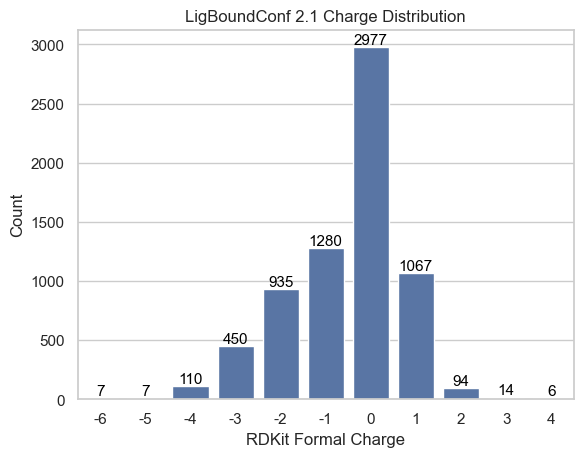

In [26]:
ax = sns.countplot(data=mace, x="formal_charge")

ax.set(title="LigBoundConf 2.1 Charge Distribution", xlabel="RDKit Formal Charge", ylabel="Count")

# add counts above the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=11, color='black', xytext=(0, 5), textcoords='offset points')
plt.show()

In [33]:
def calculate_radius_of_gyration(mol, conf_id=-1, use_weights=True):
    """
    Calculates the Radius of Gyration (Rg) for a specific conformer.
    
    Args:
        mol (rdkit.Chem.Mol): The molecule object.
        conf_id (int): The conformer ID to evaluate (default -1 for latest).
        use_weights (bool): If True, calculates mass-weighted Rg (standard). 
                            If False, calculates geometric Rg.
    
    Returns:
        float: The Radius of Gyration in Angstroms.
    """
    conf = mol.GetConformer(conf_id)
    positions = conf.GetPositions()
    num_atoms = mol.GetNumAtoms()
    
    if use_weights:
        weights = np.array([atom.GetMass() for atom in mol.GetAtoms()])
    else:
        weights = np.ones(num_atoms)
        
    total_weight = np.sum(weights)
    
    # Calculate Center of Mass (COM)
    # shape: (N, 3) * (N, 1) -> sum -> (3,)
    center_of_mass = np.sum(positions * weights[:, np.newaxis], axis=0) / total_weight
    
    # Calculate distance of each atom from COM
    # Broadcating subtraction of COM from positions
    deltas = positions - center_of_mass
    
    # Square distances
    sq_dists = np.sum(deltas**2, axis=1)
    
    # Weighted average of squared distances
    rg_sq = np.sum(sq_dists * weights) / total_weight
    
    return np.sqrt(rg_sq)

In [53]:
radius_gyration = []
for i, row in mace.iterrows():
    if i % 1000 == 0:
        print(i)
    crest = Chem.Mol(row.crest_gloabl_min_mol)
    rg = calculate_radius_of_gyration(crest)
    radius_gyration.append(rg)
mace["radius_gyration"] = radius_gyration

0
1000
2000
3000
4000
5000
6000


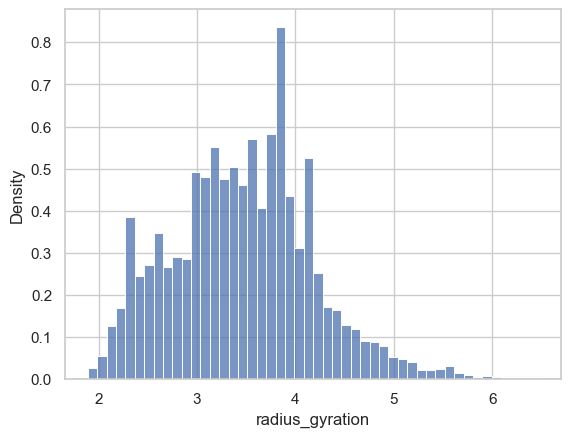

In [35]:
sns.histplot(mace.radius_gyration, label="MACE", stat="density")
plt.show()


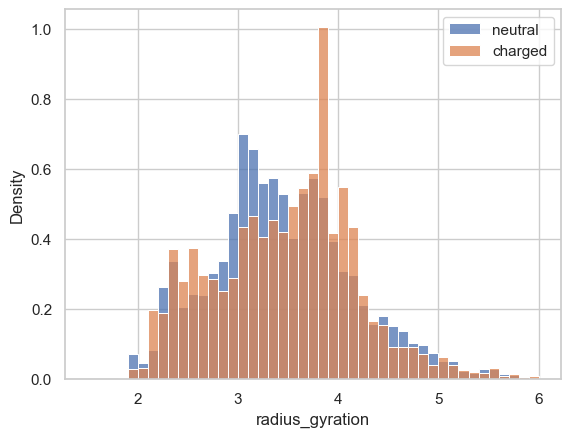

In [57]:
sns.histplot(mace[~mace.charged].radius_gyration, label="neutral", stat="density", binwidth=0.1, binrange=(1.5, 6))
sns.histplot(mace[mace.charged].radius_gyration, label="charged", stat="density", binwidth=0.1, binrange=(1.5, 6))
plt.legend()
plt.show()

In [38]:
mace

,ligand_id,formal_charge,xtb_local_min_mol,crest_gloabl_min_mol,xtb_local_min_energy,crest_global_min_energy,smiles,mol_bytes,spin_multiplicity,id,...,local_min_e,global_min_mol,global_min_e,ligand_strain,passes_strain_filter,nconfs_converged,mace_strain,rmsd,charged,radius_gyration
0,00G_3FUJ_A_710,0,b'\xef\xbe\xad\xde\x00\x00\x00\x00\x10\x00\x00...,b'\xef\xbe\xad\xde\x00\x00\x00\x00\x10\x00\x00...,-4.562781e+05,-456280.830218,[H]C1=C([H])C2=C(C([H])=C1OC([H])([H])C([H])([...,b'\xef\xbe\xad\xde\x00\x00\x00\x00\x10\x00\x00...,1,00G_3FUJ_A_710,...,-4.562784e+05,b'\xef\xbe\xad\xde\x00\x00\x00\x00\x10\x00\x00...,-4.562832e+05,4.774254,True,16,4.774254,2.164898,False,2.670596
1,01I_3MA3_A_313,-2,b'\xef\xbe\xad\xde\x00\x00\x00\x00\x10\x00\x00...,b'\xef\xbe\xad\xde\x00\x00\x00\x00\x10\x00\x00...,-6.686137e+05,-668613.914981,[H]C1=C(C(=O)[O-])OC2=C([H])C3=C4C([H])=C(C(=O...,b'\xef\xbe\xad\xde\x00\x00\x00\x00\x10\x00\x00...,1,01I_3MA3_A_313,...,-6.685034e+05,"b""\xef\xbe\xad\xde\x00\x00\x00\x00\x10\x00\x00...",-6.685040e+05,0.585522,True,3,0.585522,0.096705,True,4.091823
2,02Z_3RZB_A_458,0,"b""\xef\xbe\xad\xde\x00\x00\x00\x00\x10\x00\x00...",b'\xef\xbe\xad\xde\x00\x00\x00\x00\x10\x00\x00...,-6.777694e+05,-677769.719462,[H]C1=C([H])C([H])=C(N([H])C2=NC(N([H])[H])=C(...,"b""\xef\xbe\xad\xde\x00\x00\x00\x00\x10\x00\x00...",1,02Z_3RZB_A_458,...,-6.777702e+05,b'\xef\xbe\xad\xde\x00\x00\x00\x00\x10\x00\x00...,-6.777727e+05,2.477207,True,15,2.477207,2.191178,False,3.341682
3,03K_4EK5_A_300,0,b'\xef\xbe\xad\xde\x00\x00\x00\x00\x10\x00\x00...,b'\xef\xbe\xad\xde\x00\x00\x00\x00\x10\x00\x00...,-5.723006e+05,-572300.972592,[H]C1=C([H])C(C(=O)N([H])C2=NN([H])C(C3([H])C(...,b'\xef\xbe\xad\xde\x00\x00\x00\x00\x10\x00\x00...,1,03K_4EK5_A_300,...,-5.723016e+05,b'\xef\xbe\xad\xde\x00\x00\x00\x00\x10\x00\x00...,-5.723029e+05,1.261124,True,20,1.261124,1.755373,False,4.286572
4,03X_3U6H_A_1,0,b'\xef\xbe\xad\xde\x00\x00\x00\x00\x10\x00\x00...,b'\xef\xbe\xad\xde\x00\x00\x00\x00\x10\x00\x00...,-1.139778e+06,NaN,[H]C1=C([H])C(OC2=C([H])C([H])=C(N([H])C(=O)C3...,b'\xef\xbe\xad\xde\x00\x00\x00\x00\x10\x00\x00...,1,03X_3U6H_A_1,...,-1.139777e+06,b'\xef\xbe\xad\xde\x00\x00\x00\x00\x10\x00\x00...,-1.139780e+06,3.873451,True,18,3.873451,0.898109,False,6.276336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6942,ZYV_2WMV_A_1271,1,b'\xef\xbe\xad\xde\x00\x00\x00\x00\x10\x00\x00...,b'\xef\xbe\xad\xde\x00\x00\x00\x00\x10\x00\x00...,-4.983405e+05,-498344.545441,[H]C1=NC2=C(N=C([H])N2[H])C(N2C([H])([H])C([H]...,b'\xef\xbe\xad\xde\x00\x00\x00\x00\x10\x00\x00...,1,ZYV_2WMV_A_1271,...,-4.984750e+05,"b""\xef\xbe\xad\xde\x00\x00\x00\x00\x10\x00\x00...",-4.984823e+05,7.341542,True,21,7.341542,1.256535,True,2.756787
6943,ZZ3_2WI2_A_1226,0,b'\xef\xbe\xad\xde\x00\x00\x00\x00\x10\x00\x00...,b'\xef\xbe\xad\xde\x00\x00\x00\x00\x10\x00\x00...,-5.101256e+05,-510125.782397,[H]N([H])C1=NC(C([H])([H])[H])=NC(SC([H])([H])...,b'\xef\xbe\xad\xde\x00\x00\x00\x00\x10\x00\x00...,1,ZZ3_2WI2_A_1226,...,-5.101255e+05,b'\xef\xbe\xad\xde\x00\x00\x00\x00\x10\x00\x00...,-5.101262e+05,0.630562,True,5,0.630562,0.329820,False,2.300678
6944,ZZA_2VCW_B_1201,-1,b'\xef\xbe\xad\xde\x00\x00\x00\x00\x10\x00\x00...,b'\xef\xbe\xad\xde\x00\x00\x00\x00\x10\x00\x00...,-4.052068e+05,-405206.962423,[H]C1=NN(C2=C([H])C([H])=C([H])C([H])=C2[H])C(...,b'\xef\xbe\xad\xde\x00\x00\x00\x00\x10\x00\x00...,1,ZZA_2VCW_B_1201,...,-4.051353e+05,b'\xef\xbe\xad\xde\x00\x00\x00\x00\x10\x00\x00...,-4.051359e+05,0.585522,True,14,0.585522,0.275551,True,3.029531
6945,ZZY_2WD1_A_2347,0,b'\xef\xbe\xad\xde\x00\x00\x00\x00\x10\x00\x00...,b'\xef\xbe\xad\xde\x00\x00\x00\x00\x10\x00\x00...,-9.623305e+05,-962332.394424,[H]C1=NC2=C(C([H])=C1C(=O)N([H])[H])N(S(=O)(=O...,b'\xef\xbe\xad\xde\x00\x00\x00\x00\x10\x00\x00...,1,ZZY_2WD1_A_2347,...,-9.623374e+05,b'\xef\xbe\xad\xde\x00\x00\x00\x00\x10\x00\x00...,-9.623449e+05,7.476662,True,15,7.476662,2.103694,False,3.218351


<Axes: xlabel='charged', ylabel='radius_gyration'>

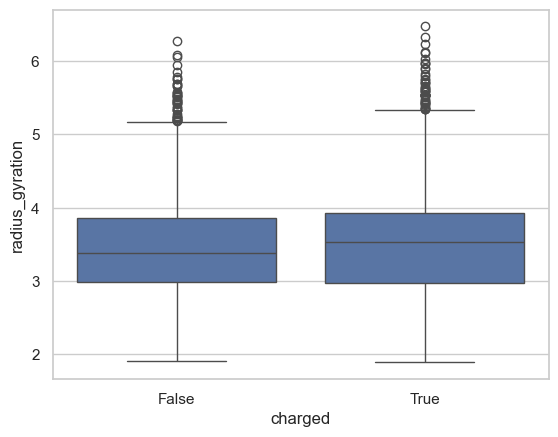

In [ ]:
sns.boxplot(x="charged", y="radius_gyration", data=mace)

In [ ]:
# I want the raw conformers

In [ ]:
def calculate_polar_sasa(mol, conf_id=-1):
    """
    Calculates the 3D Solvent Accessible Surface Area (SASA) for polar atoms only.
    
    This function uses rdFreeSASA to compute atomic SASA contributions and 
    sums them for N, O, and Polar Hydrogens.
    
    Args:
        mol (rdkit.Chem.Mol): The molecule object.
        conf_id (int): The conformer ID to evaluate.
        
    Returns:
        tuple: (Polar_SASA, Total_SASA, Polar_Ratio)
    """
    # 1. Classify atoms for SASA radii (Protonated/Hydrophobic/etc standard vdw)
    radii = rdFreeSASA.classifyAtoms(mol)
    
    # 2. Compute SASA
    # This function returns the total SASA and, crucially, updates the 
    # 'SASA' property on each atom in the molecule.
    sasa_opts = rdFreeSASA.SASAOpts(rdFreeSASA.SASAAlgorithm.ShrakeRupley)
    total_sasa = rdFreeSASA.CalcSASA(mol, radii, confIdx=conf_id, opts=sasa_opts)
    
    polar_sasa = 0.0
    
    for atom in mol.GetAtoms():
        # Get the SASA value calculated for this specific atom
        # Note: rdFreeSASA stores the value in a property named "SASA"
        try:
            atom_area = atom.GetDoubleProp("SASA")
        except KeyError:
            # Fallback if property isn't set (older RDKit versions)
            # You might need to check your RDKit version if this hits.
            continue
            
        # Define Polar Atoms:
        # 1. Nitrogen (7) and Oxygen (8) are definitely polar
        # 2. Polar Hydrogens: H attached to N or O
        is_polar = False
        atomic_num = atom.GetAtomicNum()
        
        if atomic_num in [7, 8]: # N, O
            is_polar = True
        elif atomic_num == 1: # H
            # Check neighbors to see if it is polar
            bond = atom.GetBonds()[0] # H only has one bond
            neighbor = bond.GetOtherAtom(atom)
            if neighbor.GetAtomicNum() in [7, 8]:
                is_polar = True
                
        if is_polar:
            polar_sasa += atom_area
            
    polar_ratio = polar_sasa / total_sasa if total_sasa > 0 else 0.0
    
    return polar_sasa, total_sasa, polar_ratio

In [54]:
polar_sasa_list = []
total_sasa_list = []
polar_ratio_list = []

for i, row in mace.iterrows():
    if i % 1000 == 0:
        print(i)
    polar_sasa, total_sasa, polar_ratio = calculate_polar_sasa(Chem.Mol(row.crest_gloabl_min_mol))
    polar_sasa_list.append(polar_sasa)
    total_sasa_list.append(total_sasa)
    polar_ratio_list.append(polar_ratio)



0


ArgumentError: Python argument types in
    SASAOpts.__init__(SASAOpts, SASAAlgorithm)
did not match C++ signature:
    __init__(_object* self, FreeSASA::SASAOpts::Algorithm alg, FreeSASA::SASAOpts::Classifier cls, double pr)
    __init__(_object* self, FreeSASA::SASAOpts::Algorithm alg, FreeSASA::SASAOpts::Classifier cls)
    __init__(_object* self)

In [14]:
rmsds = []
for i, row in mace.iterrows():
    print(i)
    xtb = Chem.Mol(row.xtb_local_min_mol)
    crest = Chem.Mol(row.crest_gloabl_min_mol)
    rdMolAlign.AlignMol(xtb, crest)
    rmsd = Chem.rdMolAlign.GetBestRMS(xtb, crest)
    rmsds.append(rmsd)
mace["rmsd"] = rmsds

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

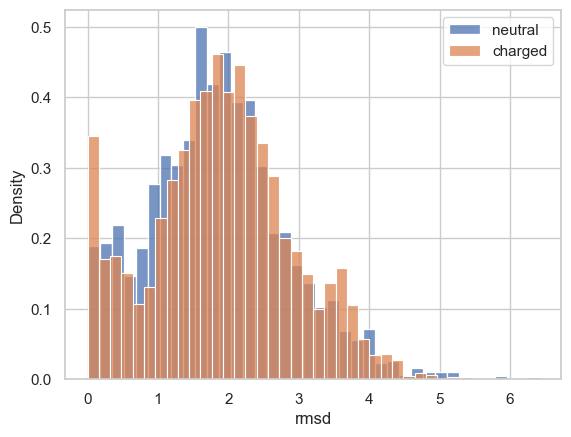

In [17]:
sns.histplot(mace[mace.formal_charge == 0].rmsd, label="neutral", stat="density")
sns.histplot(mace[mace.formal_charge != 0].rmsd, label="charged", stat="density")
plt.legend()
plt.show()

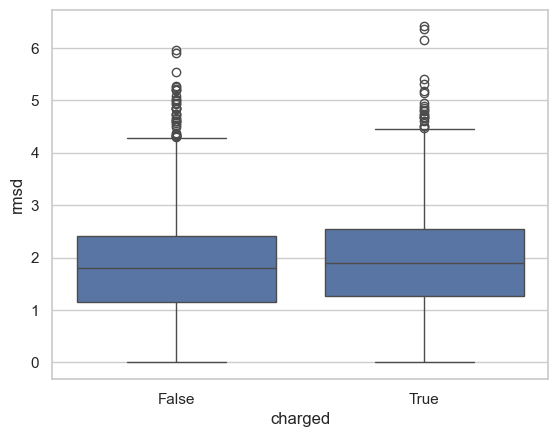

In [18]:
mace["charged"] = mace.formal_charge != 0
sns.boxplot(x="charged", y="rmsd", data=mace)
plt.show()


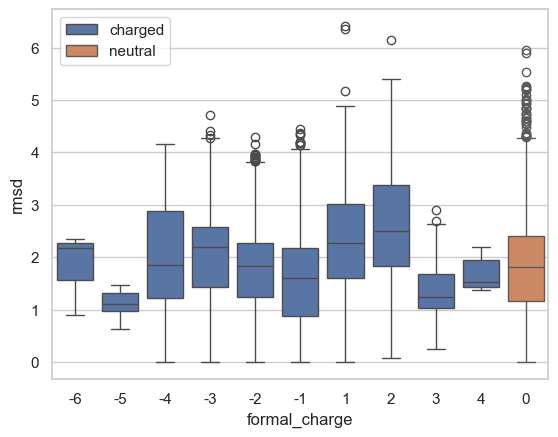

In [ ]:
sns.boxplot(x="formal_charge", y="rmsd", data=mace[mace.formal_charge != 0], label="charged")
sns.boxplot(x="formal_charge", y="rmsd", data=mace[mace.formal_charge == 0], label="neutral")
plt.legend()
plt.show()

In [7]:
mace.head()

,ligand_id,formal_charge,xtb_local_min_mol,crest_gloabl_min_mol,xtb_local_min_energy,crest_global_min_energy,smiles,mol_bytes,spin_multiplicity,id,local_min_mol,local_min_e,global_min_mol,global_min_e,ligand_strain,passes_strain_filter,nconfs_converged,mace_strain
0,00G_3FUJ_A_710,0,b'\xef\xbe\xad\xde\x00\x00\x00\x00\x10\x00\x00...,b'\xef\xbe\xad\xde\x00\x00\x00\x00\x10\x00\x00...,-4.562781e+05,-456280.830218,[H]C1=C([H])C2=C(C([H])=C1OC([H])([H])C([H])([...,b'\xef\xbe\xad\xde\x00\x00\x00\x00\x10\x00\x00...,1,00G_3FUJ_A_710,b'\xef\xbe\xad\xde\x00\x00\x00\x00\x10\x00\x00...,-4.562784e+05,b'\xef\xbe\xad\xde\x00\x00\x00\x00\x10\x00\x00...,-4.562832e+05,4.774254,True,16,4.774254
1,01I_3MA3_A_313,-2,b'\xef\xbe\xad\xde\x00\x00\x00\x00\x10\x00\x00...,b'\xef\xbe\xad\xde\x00\x00\x00\x00\x10\x00\x00...,-6.686137e+05,-668613.914981,[H]C1=C(C(=O)[O-])OC2=C([H])C3=C4C([H])=C(C(=O...,b'\xef\xbe\xad\xde\x00\x00\x00\x00\x10\x00\x00...,1,01I_3MA3_A_313,b'\xef\xbe\xad\xde\x00\x00\x00\x00\x10\x00\x00...,-6.685034e+05,"b""\xef\xbe\xad\xde\x00\x00\x00\x00\x10\x00\x00...",-6.685040e+05,0.585522,True,3,0.585522
2,02Z_3RZB_A_458,0,"b""\xef\xbe\xad\xde\x00\x00\x00\x00\x10\x00\x00...",b'\xef\xbe\xad\xde\x00\x00\x00\x00\x10\x00\x00...,-6.777694e+05,-677769.719462,[H]C1=C([H])C([H])=C(N([H])C2=NC(N([H])[H])=C(...,"b""\xef\xbe\xad\xde\x00\x00\x00\x00\x10\x00\x00...",1,02Z_3RZB_A_458,b'\xef\xbe\xad\xde\x00\x00\x00\x00\x10\x00\x00...,-6.777702e+05,b'\xef\xbe\xad\xde\x00\x00\x00\x00\x10\x00\x00...,-6.777727e+05,2.477207,True,15,2.477207
3,03K_4EK5_A_300,0,b'\xef\xbe\xad\xde\x00\x00\x00\x00\x10\x00\x00...,b'\xef\xbe\xad\xde\x00\x00\x00\x00\x10\x00\x00...,-5.723006e+05,-572300.972592,[H]C1=C([H])C(C(=O)N([H])C2=NN([H])C(C3([H])C(...,b'\xef\xbe\xad\xde\x00\x00\x00\x00\x10\x00\x00...,1,03K_4EK5_A_300,b'\xef\xbe\xad\xde\x00\x00\x00\x00\x10\x00\x00...,-5.723016e+05,b'\xef\xbe\xad\xde\x00\x00\x00\x00\x10\x00\x00...,-5.723029e+05,1.261124,True,20,1.261124
4,03X_3U6H_A_1,0,b'\xef\xbe\xad\xde\x00\x00\x00\x00\x10\x00\x00...,b'\xef\xbe\xad\xde\x00\x00\x00\x00\x10\x00\x00...,-1.139778e+06,NaN,[H]C1=C([H])C(OC2=C([H])C([H])=C(N([H])C(=O)C3...,b'\xef\xbe\xad\xde\x00\x00\x00\x00\x10\x00\x00...,1,03X_3U6H_A_1,b'\xef\xbe\xad\xde\x00\x00\x00\x00\x10\x00\x00...,-1.139777e+06,b'\xef\xbe\xad\xde\x00\x00\x00\x00\x10\x00\x00...,-1.139780e+06,3.873451,True,18,3.873451
